# Определение возраста покупателей

# Описание задачи

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:   
 - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
 - Контролировать добросовестность кассиров при продаже алкоголя.
 
# Задача
Построить модель, которая по фотографии определит приблизительный возраст человека. 

# Цель
Достичь KPI качества модели MAE не выше 8

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, Conv2D, AvgPool2D, Flatten,  GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [3]:
labels.head(10)


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


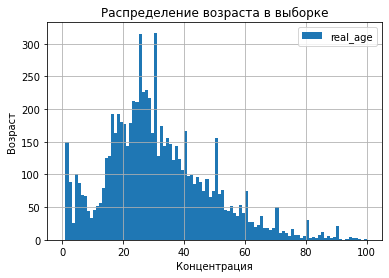

In [4]:
labels['real_age'].hist(range=(0,100), bins=100, label = 'real_age')
plt.title('Распределение возраста в выборке')
plt.ylabel('Возраст')
plt.xlabel('Концентрация')
plt.legend()
plt.show()


In [5]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Выборка фотографий смещена в сторону более молодых, средний возраст 31 год, для нашей задачи это целесообразно, так как это средний экономически активный возраст. При этом представлены все возраста от 1 года до 100 лет. всего представлено 7591 записей с указанием возраста. При этом мы видим выбросы в низких возрастах, то есть довольно много детей попало в обучающую выборку. Но главный для нас в условиях поставленной задачи момент - что выборка недостаточна для обучения, так как возраста в диапазоне от 1 до 100, а данных всего 7591, при условии, что рекомендуемое количество единиц для обучения - 1000 на один класс. Соответственно в построении модели важно учесть данный факт и увеличить выборку. 

In [6]:

train_datagen = ImageDataGenerator(rescale=1./255,
                                  validation_split=0.25)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

val_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

Found 5694 validated image filenames.
Found 1897 validated image filenames.


In [7]:
features, target = next(train_gen_flow)


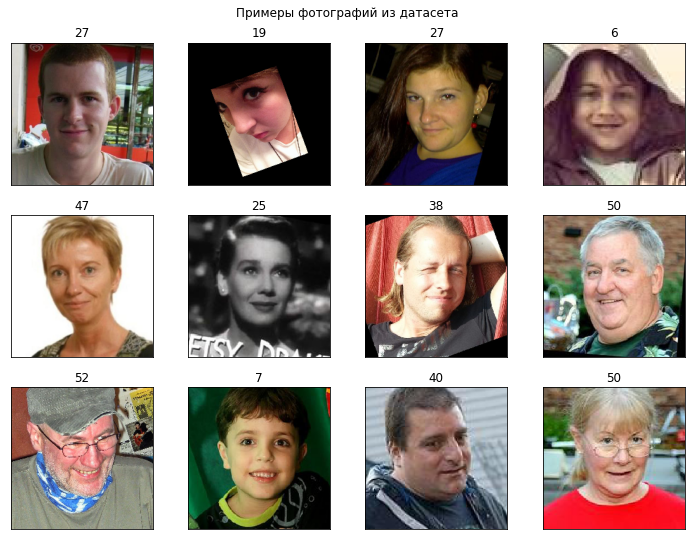

In [8]:
fig = plt.figure(figsize=(10,10))
plt.suptitle('Примеры фотографий из датасета')
for i in range(12):
    ax=fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    ax.set_title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
   
    

Датасет представлен фотографиями лиц людей с указанием возраста, в том числе с разным поворотом головы, в очках и головных уборах. Это хорошо, так как в магазин люди приходят по-разному одеты и не будут стоять ровно перед камерой.   
При этом из-за смещения возраста в сторону 30 лет - вероятно, модель точнее будет определять эти возраста и хуже людей старше 40 лет. Наша задача при построении модели учесть эту особенность датасета и увеличить выборку для обучения модели.   
Также важно отметить, что фотографии правильной ориентации, соответственно можно работать с ними в текущем виде и их ненужно (и даже нельзя) поворачивать. Все фотографии в одном размере, среди них есть как цветные, так и черно-белые фотографии.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

In [9]:

def load_train(path):
    train_datagen = ImageDataGenerator(rescale=1./255,
                                      validation_split=0.25,
                                      horizontal_flip=True,
                                       zoom_range=0.2
                                      )
    labels = pd.read_csv(path + 'labels.csv')

    train_datagen_flow = train_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=(path + '/final_files/'),
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='training',
            seed=12345)
    
    return train_datagen_flow


def load_test(path):
    val_datagen = ImageDataGenerator(rescale=1./255,
                                      validation_split=0.25)
    labels = pd.read_csv(path + 'labels.csv')

    val_datagen_flow = val_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=(path + '/final_files/'),
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='validation',
            seed=12345)
    
    return val_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False) 
    

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    optimizer = Adam(lr=0.0007)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5, steps_per_epoch=None, validation_steps=None):

    
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

Результат обучения модели на GPU:

Train for 178 steps, validate for 60 steps
Epoch 1/7

178/178 - 104s - loss: 258.2300 - mae: 11.5863 - val_loss: 1047.4897 - val_mae: 27.7300  
Epoch 2/7  
178/178 - 96s - loss: 89.9865 - mae: 7.1705 - val_loss: 681.6251 - val_mae: 20.9404  
Epoch 3/7  
178/178 - 95s - loss: 69.5496 - mae: 6.3435 - val_loss: 264.5336 - val_mae: 12.2849   
Epoch 4/7  
178/178 - 96s - loss: 54.7264 - mae: 5.6737 - val_loss: 230.7213 - val_mae: 12.2229  
Epoch 5/7  
178/178 - 96s - loss: 46.3599 - mae: 5.2504 - val_loss: 82.7659 - val_mae: 6.8107  
Epoch 6/7  
178/178 - 96s - loss: 37.8952 - mae: 4.7364 - val_loss: 71.2786 - val_mae: 6.3275  
Epoch 7/7  
178/178 - 95s - loss: 32.1582 - mae: 4.4041 - val_loss: 84.5994 - val_mae: 6.7170  
  
  
60/60 - 11s - loss: 84.5994 - mae: 6.7170  
<b>Test MAE: 6.7170</b>

## Анализ обученной модели

Для цели определения возраста покупателей для сети магазинов мы взяли тестовую выборку фотографий людей в возрасте от 1 до 100 лет в количестве 7591 запись. Данная выборка была смещена влево и при этом недостаточного объема для качественного обучения модели.   
Была построена нейронная сеть для определения возраста по фотографии. Для того, чтобы увеличить объем обучающей выборки была применена аугментация, отражены фотографии по горизонтали и применен zoom.   
На полученных данных была обучена нейронная сеть ResNet50.  
Использовалась предобученная на Imagenet сеть, у которой убрали два последних слоя и адаптировали их ддя нашей задачи - использовали один нейрон и активацию ReLu, которая позволяет достичь высоких результатов в регрессионном анализе, где не может быть отрицательного результата.  
MAE обученной модели на тестовой выборке 6.717, таким образом, полученная модель может определить с точностью до 6,7 лет возраст покупателя, по его фотографии. Таким образом, рекомендуем для дальнейшего исследования использовать не конкретные возраста, а возрастные группы, например по 10 лет. ПРи этом следующим шагом следует проверить гипотезу - отличается ли поведение покупателей по десятилетним когортам, лабо в данном случае влияют другие факторы (например, пол). И достаточно ли 10-летней когорты, либо нужны более узкие - в пределах не более 5 лет. От данной информации будет зависеть - решает ли полученная модель поставленную перед бизнесом задачу, либо нужно искать другие варианты решения.